In [1]:
import os
import platform
import pandas as pd
import cv2 as cv
import json
import numpy as np
import tensorflow as tf

from tqdm import tqdm
from glob import glob, iglob
from matplotlib import image, pyplot as plt, patches

2022-02-16 08:33:44.427301: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-16 08:33:44.427351: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
gt_train = pd.read_csv('../assets/dataset/gt_train.csv')

In [2]:
with open('../assets/dataset/raw_train.txt') as json_file:
    data = json.load(json_file)
    

In [27]:
data[1]

{'filename': '00061332.jpg',
 'image-size': [480, 720],
 'objects': [{'class': 'car',
   'x': 0.4930555555555556,
   'y': 0.7041666666666667,
   'w': 0.25,
   'h': 0.2916666666666667}]}

In [118]:
for idx in tqdm(range(len(data))):
  df = gt_train.loc[gt_train["00000000"] == int(data[idx]["filename"].replace(".jpg", ""))]
  objects = []
  for x in range(len(df)):
    obj = {
      "class" : df.iloc[x,1],
      "x" : df.iloc[x,2] / data[idx]["image-size"][1],
      "y" : df.iloc[x,3] / data[idx]["image-size"][0],
      "w" : (df.iloc[x,4] - df.iloc[x,2]) / data[idx]["image-size"][1],
      "h" : (df.iloc[x,5] - df.iloc[x,3]) / data[idx]["image-size"][0]
    }
    objects.append(obj) 
  data[idx]["objects"] = objects


100%|██████████| 110000/110000 [03:53<00:00, 471.61it/s]


In [33]:
def open_image(path, name, show = False):
    if platform.system() == 'Windows':
        idx = name.replace('/'," ").split(" ")
        name = os.path.join(idx[0], idx[1])
    
    path = os.path.join(path,name)
    img = image.imread(path)
    
    if show:
        plt.figure(figsize = (15,15))
        plt.imshow(img, interpolation='nearest')
        plt.show()
    
    return img

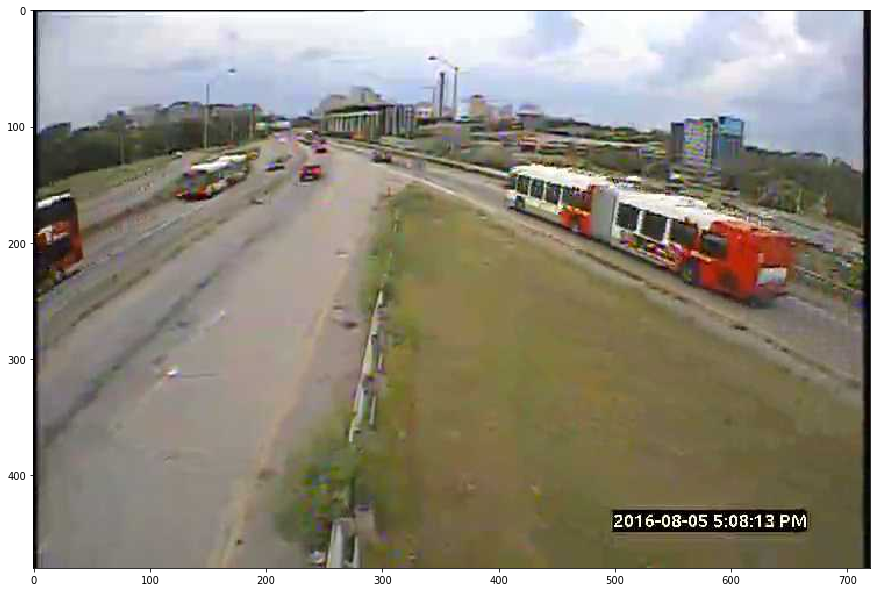

(480, 720, 3)


In [34]:
img = open_image('../assets/dataset/train', data[5]["filename"], True)
print(img.shape)

In [35]:
def draw_image(image, notation):
  fig, ax = plt.subplots(figsize = (15,15))
  ax.imshow(image, interpolation='nearest')
  objs = notation["objects"]
  h = notation["image-size"][0]
  w = notation["image-size"][1]
  for obj in objs:
    rect = patches.Rectangle((int(obj["x"]* w), int(obj["y"] * h)), int(obj["w"] * w), int(obj["h"] * h), linewidth=1, edgecolor='r', facecolor='none') 
    ax.add_patch(rect)
  
  plt.show()

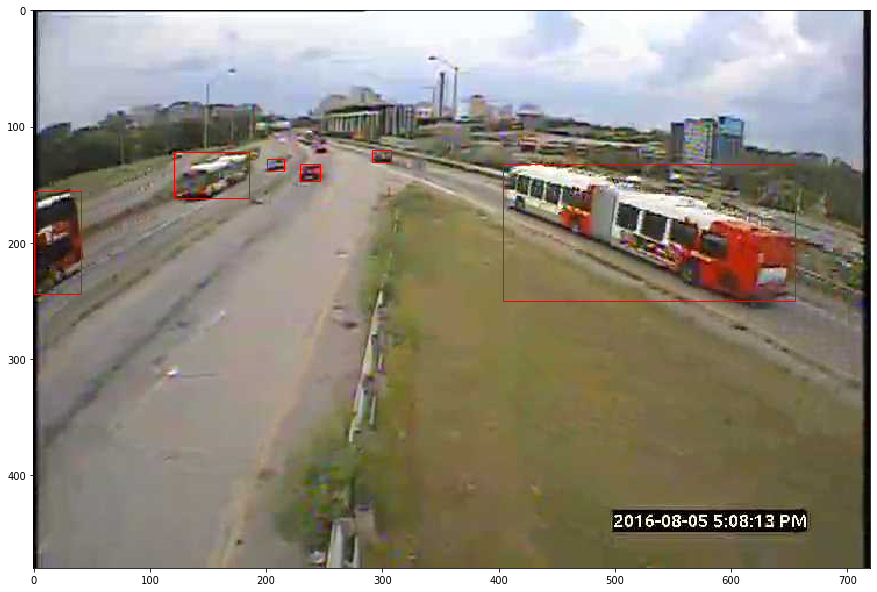

In [36]:
draw_image(img,data[5])

In [119]:
with open('../assets/dataset/raw_train.txt', 'w') as file:
    json.dump(data, file)

In [39]:
def get_data(data, image_path, class_name, target_image_shape, max_boxes=100):
    if platform.system() == 'Windows':
        name = data['filename'].replace("/", "\\")
    else:
        name = data['filename']
    filepath = os.path.join(image_path, name)
    img = image.imread(filepath) / 255
    if img.shape != target_image_shape:
        img = tf.image.resize(img, (target_image_shape[0], target_image_shape[1]))
    boxes = np.array([[x['x'], x['y'], x['w'], x['h'], class_name.index(x['class'])] for x in data['objects']])
    boxes_data = np.zeros((max_boxes, 5))

    if len(boxes) > 0:
        np.random.shuffle(boxes)
        boxes = boxes[:max_boxes]
        boxes[:, [0, 2]] = boxes[:, [0, 2]] * target_image_shape[0]
        boxes[:, [1, 3]] = boxes[:, [1, 3]] * target_image_shape[1]
        boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] + boxes[:, 1]

        boxes_data[:len(boxes)] = boxes

    return img, boxes_data

In [40]:
class_name = [line.strip() for line in open('../assets/class_name.txt').readlines()]
print(class_name)
class_name.index('car')

['articulated_truck', 'bicycle', 'bus', 'car', 'motorcycle', 'motorized_vehicle', 'non-motorized_vehicle', 'pedestrian', 'pickup_truck', 'single_unit_truck', 'work_van']


3

In [48]:

img, boxes = get_data(data[5], '../assets/dataset/train',class_name, (460, 460, 3), 100)
print(img.shape)
print(boxes)

(460, 460, 3)
[[ 77.30555556 117.875      118.19444444 155.25         2.        ]
 [  0.         148.54166667  26.19444444 233.83333333   2.        ]
 [258.11111111 126.5        418.47222222 239.58333333   2.        ]
 [146.94444444 126.5        157.80555556 140.875        3.        ]
 [185.91666667 115.         196.13888889 124.58333333   3.        ]
 [128.41666667 122.66666667 137.36111111 132.25         3.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.  